In [ ]:
pip install torch torchvision matplotlib pillow

In [ ]:
content_path = "/content/Mona_Lisa.jpg"
style_path = "/content/mixed_color.jpg"

In [ ]:
import torch
from torchvision import transforms, models
from PIL import Image
import matplotlib.pyplot as plt

In [ ]:
def load_image(image_path, max_size=400):
    image = Image.open(image_path).convert("RGB")
    size = max_size if max(image.size) > max_size else max(image.size)
    transform = transforms.Compose([
        transforms.Resize((size, size)),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])
    return transform(image).unsqueeze(0)


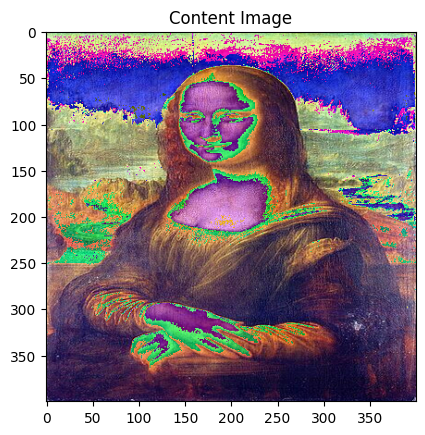

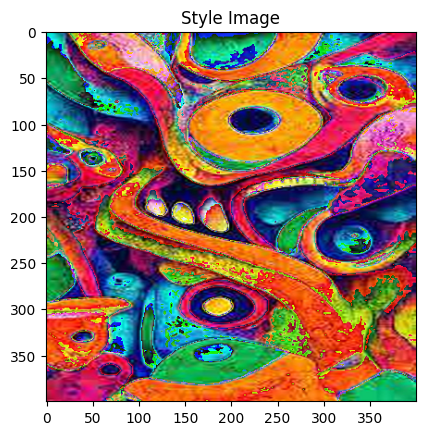

In [ ]:
content_image = load_image("/content/Mona_Lisa.jpg")
style_image = load_image("/content/mixed_color.jpg")

In [ ]:
vgg = models.vgg19(pretrained=True).features
for param in vgg.parameters():
    param.requires_grad = False

In [ ]:
def get_features(image, model, layers):
    features = {}
    x = image
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[name] = x
    return features

content_layers = ['21']
style_layers = ['0', '5', '10', '19', '28']  # conv1_1, conv2_1, etc.

content_features = get_features(content_image, vgg, content_layers)
style_features = get_features(style_image, vgg, style_layers)

In [ ]:

def gram_matrix(tensor):
    _, d, h, w = tensor.size()
    tensor = tensor.view(d, h * w)
    gram = torch.mm(tensor, tensor.t())
    return gram / (d * h * w)

In [ ]:
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_layers}

In [ ]:
target = content_image.clone().requires_grad_(True)
optimizer = torch.optim.Adam([target], lr=0.003)

style_weight = 1e10
content_weight = 1e5

In [ ]:
def calculate_loss(target_features, content_features, style_grams, style_layers):
    content_loss = torch.mean((target_features['21'] - content_features['21']) ** 2)

    style_loss = 0
    for layer in style_layers:
        target_gram = gram_matrix(target_features[layer])
        style_loss += torch.mean((target_gram - style_grams[layer]) ** 2)

    total_loss = content_weight * content_loss + style_weight * style_loss
    return total_loss


Step 0, Loss: 185.0146


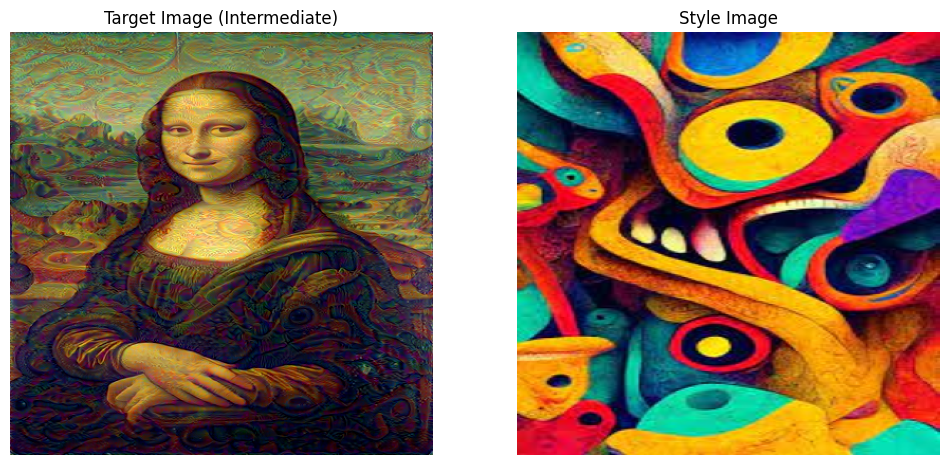

In [ ]:
for step in range(3001):
    target_features = get_features(target, vgg, content_layers + style_layers)
    loss = calculate_loss(target_features, content_features, style_grams, style_layers)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if step % 500 == 0:
        print(f"Step {step}, Loss: {loss.item():.4f}")


        plt.figure(figsize=(12, 6))


        target_img = target.clone().detach().squeeze(0)
        target_img = target_img.cpu().numpy().transpose(1, 2, 0)
        target_img = target_img * (0.229, 0.224, 0.225) + (0.485, 0.456, 0.406)
        plt.subplot(1, 2, 1)
        plt.imshow(target_img.clip(0, 1))
        plt.title("Target Image (Intermediate)")
        plt.axis('off')


        style_img = style_image.clone().detach().squeeze(0)
        style_img = style_img.cpu().numpy().transpose(1, 2, 0)
        style_img = style_img * (0.229, 0.224, 0.225) + (0.485, 0.456, 0.406)
        plt.subplot(1, 2, 2)
        plt.imshow(style_img.clip(0, 1))
        plt.title("Style Image")
        plt.axis('off')

        plt.show()
